### Working with distributed data

Let's see how to make some Data analisys on distributed dataset

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:35139 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


Let's create a random timeseries dataset with the following attributes:

+ It stores a record for every 10 seconds of the year 2000

+ It splits that year by month, keeping every month as a separate Pandas dataframe

+ Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 480 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [3]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries(start='2019-03-01', end='2019-04-30')

In [4]:
df

,id,name,x,y
npartitions=60,,,,
2019-03-01,int64,object,float64,float64
2019-03-02,...,...,...,...
...,...,...,...,...
2019-04-29,...,...,...,...
2019-04-30,...,...,...,...


In [5]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

In [6]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [7]:
df.head(3)

,id,name,x,y
timestamp,,,,
2019-03-01 00:00:00,995,Alice,0.89,-0.10
2019-03-01 00:00:01,1013,Norbert,0.58,0.86
2019-03-01 00:00:02,1037,Ursula,0.18,-0.16


In [8]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

/usr/local/lib/python2.7/dist-packages/dask/dataframe/utils.py:391: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  tz=idx.tz, name=idx.name)


Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 311 tasks

In [9]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [10]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

### Persist data in memory
If you have the available RAM for your dataset then you can persist data in memory.

This allows future computations to be much faster.



In [11]:
df = df.persist()

### Time Series Operations
Because we have a datetime index time-series operations work efficiently

In [12]:
%matplotlib inline

df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2019-03-01 00:00:00,-9.77e-03,3.83e-03
2019-03-01 01:00:00,-1.89e-02,-1.68e-02
2019-03-01 02:00:00,-2.14e-03,1.48e-03
2019-03-01 03:00:00,-6.31e-03,-2.07e-02
2019-03-01 04:00:00,2.31e-03,1.00e-02


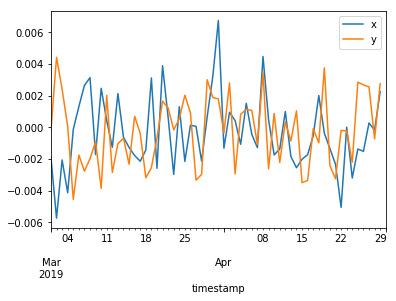

In [13]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [14]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2019-03-01 00:00:00,0.89,-0.10
2019-03-01 00:00:01,0.74,0.38
2019-03-01 00:00:02,0.55,0.20
2019-03-01 00:00:03,0.18,-0.05
2019-03-01 00:00:04,0.32,0.05


In [15]:
df.loc['2019-04-05']

,id,name,x,y
npartitions=1,,,,
2019-04-05 00:00:00.000000000,int64,object,float64,float64
2019-04-05 23:59:59.999999999,...,...,...,...


In [16]:
%time df.loc['2019-04-05'].compute()

CPU times: user 39.1 ms, sys: 30.4 ms, total: 69.5 ms
Wall time: 229 ms


,id,name,x,y
timestamp,,,,
2019-04-05 00:00:00,1020,Frank,0.77,0.40
2019-04-05 00:00:01,1001,Ursula,0.53,0.70
2019-04-05 00:00:02,1002,Bob,0.27,-0.41
2019-04-05 00:00:03,941,Laura,0.33,0.98
2019-04-05 00:00:04,970,Kevin,0.38,0.58
...,...,...,...,...
2019-04-05 23:59:55,1069,Xavier,0.99,0.20
2019-04-05 23:59:56,1038,Yvonne,0.99,0.84
2019-04-05 23:59:57,1017,Hannah,-0.32,-0.32


### Set Index
Data is sorted by the index column. 
This allows for faster access, joins, groupby-apply operations, etc.. However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [17]:
df = df.set_index('name')
df

,id,x,y
npartitions=60,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Again, because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [18]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name. 
As a result operations like random access are cheap and efficient

In [19]:
%time df.loc['Alice'].compute()

CPU times: user 81.1 ms, sys: 37.9 ms, total: 119 ms
Wall time: 353 ms


,id,x,y
name,,,
Alice,995,0.89,-0.10
Alice,1017,0.95,-0.73
Alice,983,-0.68,0.36
Alice,1002,-0.30,0.95
Alice,1002,-0.75,0.32
...,...,...,...
Alice,979,-0.50,-0.46
Alice,1025,-0.30,-0.94
Alice,1034,-0.22,0.86


### Groupby-Apply a simple way to work on large datasets
Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [20]:
from  sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression(copy_X=True, fit_intercept=Tr...
Bob        LinearRegression(copy_X=True, fit_intercept=Tr...
Charlie    LinearRegression(copy_X=True, fit_intercept=Tr...
Dan        LinearRegression(copy_X=True, fit_intercept=Tr...
Edith      LinearRegression(copy_X=True, fit_intercept=Tr...
                                 ...                        
Victor     LinearRegression(copy_X=True, fit_intercept=Tr...
Wendy      LinearRegression(copy_X=True, fit_intercept=Tr...
Xavier     LinearRegression(copy_X=True, fit_intercept=Tr...
Yvonne     LinearRegression(copy_X=True, fit_intercept=Tr...
Zelda      LinearRegression(copy_X=True, fit_intercept=Tr...
Length: 26, dtype: object

In [21]:
from dask_ml.linear_model import LinearRegression

In [24]:
lr = LinearRegression()
lr.fit(df.x.values.reshape(len(df), 1), df.y.values)

ValueError: ('Array chunk size or shape is unknown. shape: %s', (nan,))